# Pearson correlation with uncertainty

In [1]:
import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import numpy as np
import bayesflow as bf
import matplotlib.pyplot as plt

INFO:bayesflow:Using backend 'jax'

In this example we will estimate a Pearson’s correlation coefficient,
assuming known reliability of measurement of the two variables. We will
assume that the true variable $y$ and measurement error $\epsilon$ are
independent and so the measurement variance is simply a sum of the true
and error variances, $\sigma_x^2 = \sigma^2 + \sigma_\epsilon^2$, and
reliability is then $a=\frac{\sigma^2}{\sigma_x^2}$.

### Simulator

We will amortize over a range of sample sizes and reliabilities.

In [2]:
def context():
    return dict(
        n = np.random.randint(5, 20),
        reliability = np.random.beta(a=5, b=2, size=2)
    )

def prior():
    return dict(rho = np.random.uniform(low=-1, high=1))

def likelihood(n, reliability, rho):
    sd_true = np.sqrt(reliability)
    sd_err = 1 - np.sqrt(reliability)

    y = np.random.multivariate_normal(
        mean=[0, 0], 
        cov=[
            [np.square(sd_true[0]), rho * np.prod(sd_true)], 
            [rho * np.prod(sd_true), np.square(sd_true[1])]], 
        size = n)
    e = np.random.normal(loc=0, scale=sd_err, size=(n, 2))
    x = y+e
    r = np.corrcoef(x[:,0], x[:,1])[0,1]

    return dict(r=r)

simulator = bf.make_simulator([context, prior, likelihood])


### Approximator

We will approximate the posterior of $\rho$ given sample size $n$,
mearuement reliabilities, and sample correlation coefficients.

In [3]:
adapter=(
    bf.Adapter()
    .constrain("rho", lower=-1, upper=1)
    .rename("rho", "inference_variables")
    .concatenate(["n", "reliability", "r"], into="inference_conditions")
)

In [4]:
workflow=bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=bf.networks.CouplingFlow()
)

### Training

In [ ]:
history=workflow.fit_online(epochs=20, batch_size=256)

### Validation

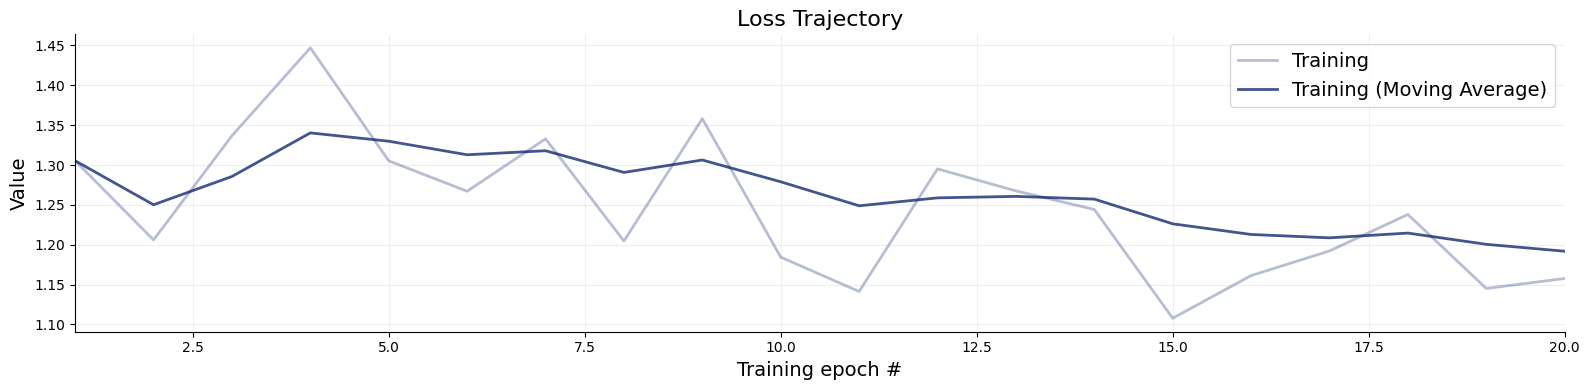

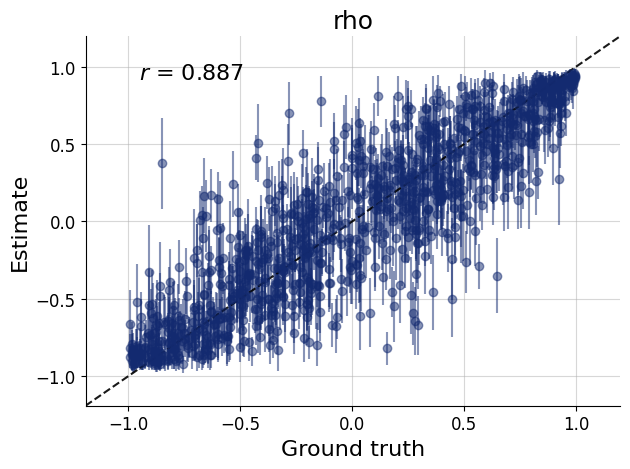

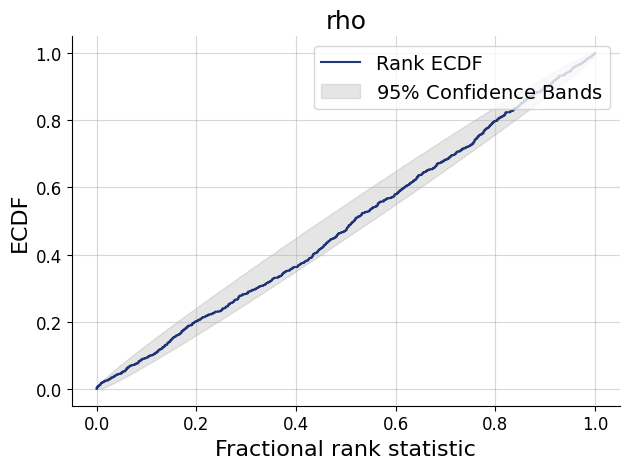

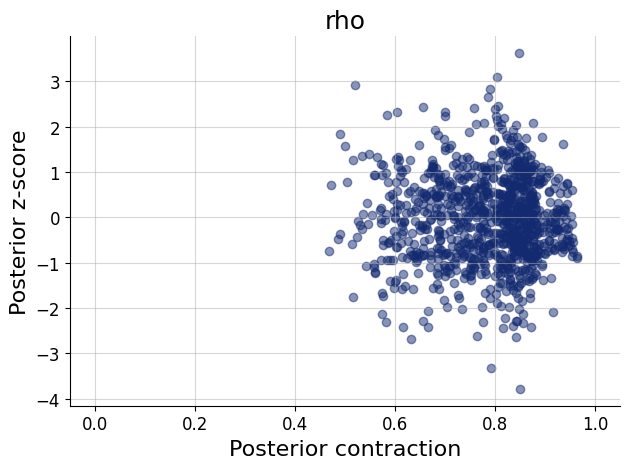

In [6]:
test_data=simulator.sample(1000)
figs=workflow.plot_default_diagnostics(test_data=test_data, num_samples=500)

### Inference

We will conduct an inference for the correlation coefficient for the
data reported in Lee & Wagenmakers (2013, p. 64) of response times and
IQ scores of 11 participants.

In [7]:
rt = [0.8, 1.0, 0.5, 0.9, 0.7, 0.4, 1.2, 1.4, 0.6, 1.1, 1.3]
iq = [102, 98, 100, 105, 103, 110, 99, 87, 113, 89, 93]

r=np.corrcoef(rt, iq)[1,0]

The original example by Lee & Wagenmakers sets the measurement error to
0.03 and 1 for RTs and IQ, respectivelly. Our model is parametrized in
terms of measurement reliability instead. We approximate the
reliabilities using the formula $1 - \sigma_\epsilon^2 / \sigma_x^2$.
Here, $\sigma_\epsilon$ are the values $0.03$ and $1$ set by Lee &
Wagenmakers (2013). In the case of RTs, we approximate $\sigma_x$ by its
sample counterpart. In the case of IQ, we set it’s $\sigma_x=15$ (since
that’s how IQ tests are standardized).

In [8]:
error_rt = 0.03
error_iq = 1
reliability = [
    1 - np.square(error_rt) / np.var(rt),
    1 - np.square(error_iq) / np.square(15)
]
reliability

[0.991, 0.9955555555555555]

In [9]:
inference_data = dict(
    r = np.array([[r]]),
    n = np.array([[len(rt)]]),
    reliability = np.array(reliability)[np.newaxis]
)

In [10]:
samples = workflow.sample(num_samples=2000, conditions=inference_data)

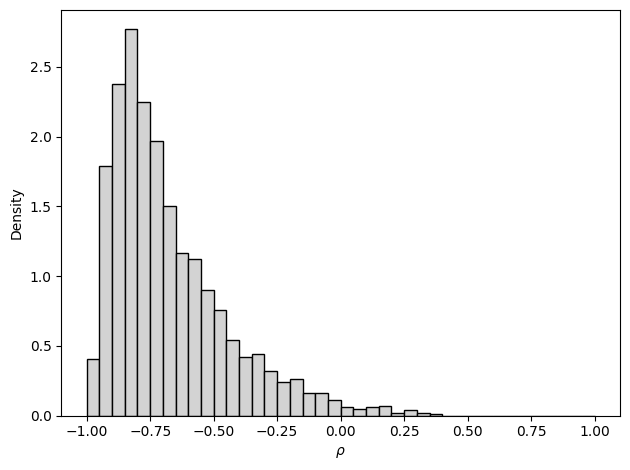

In [11]:
plt.hist(samples["rho"].flatten(), density=True, color="lightgray", edgecolor="black", bins=np.arange(-1, 1.05, 0.05))
plt.xlabel(r"$\rho$")
plt.ylabel("Density")
plt.tight_layout()

Lee, M. D., & Wagenmakers, E.-J. (2013). *Bayesian Cognitive Modeling: A
Practical Course*. Cambridge University Press.